In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
import sys
from skimage.transform import probabilistic_hough_line
from skimage.transform import hough_line, hough_line_peaks

In [2]:
PARAM_OTSU = [29, 6, 4, np.array([0, 150, 0]), np.array([179, 200, 300]), np.ones((5,5),np.uint8), np.ones((5,5),np.uint8), 0, 1, 0, 50, True, 1, 1]

#PARAM_OTSU = [29, 6, 4, np.array([0, 150, 0]), np.array([179, 200, 300]), np.ones((5,5),np.uint8), np.ones((5,5),np.uint8), 0, 1, 0, 50, False, 1, 1]
#[MIN_RAYON, EROSION, DILATATION, LO, HI, NOYAU_EROSION, NOYAU_DILATATION, TOLERANCE_RAYON, K, SEUIL_CANNY_BAS, SEUIL_CANNY_HAUT, SUPPRESSION_CERCLES, DILATATION_CERCLES, DILATATION_CANNY]

In [3]:
#PARAM_COULEURS = [29, 2, 4, np.array([0, 150, 50]), np.array([179, 200, 300]), np.ones((5,5),np.uint8), np.ones((5,5),np.uint8), 0, 1, 0, 50, True, 1, 1]

PARAM_COULEURS = [29, 1, 4, np.array([0, 150, 50]), np.array([179, 200, 300]), np.ones((5,5),np.uint8), np.ones((5,5),np.uint8), 0, 1, 0, 50, True, 1, 1]

In [12]:
EPS = 0.01

class Cercle:
    def __init__(self, x, y, r):
        self.x = x
        self.y = y
        self.r = r
    
    def __eq__(self, other):
        a = (abs(self.x -other.x) <= EPS )
        b = (abs(self.y -other.y) <= EPS )
        c = (abs(self.r -other.r) <= EPS )
        return (a and b and c)
    
    def distance(self, other):
        return ((self.x-other.x)**2 + (self.y-other.y)**2)**(0.5)  
    
    def cercles_dans(self, liste):
        """
        Retourne True si un cercle de liste a son milieu à l'interieur du cercle self.
        """
        for c in liste:
            d = self.distance(c)
            if d < self.r:
                return True
        return False
    
    def nombre_cercles_dans(self, liste):
        """
        Retourne le nombre de cercles de liste dont le centre est dans self.
        """
        res = 0
        for c in liste:
            d = self.distance(c)
            if d < self.r:
                res += 1
        return res

class ExtractionBlocs:
    def __init__(self, seuillage = "otsu", suppression_cercles = False):
        self.VERBOSE = False
        self.couleur_cercles = (0, 255, 255)
        self.seuillage = seuillage
        self.suppression_cercles = suppression_cercles
        self.photo_vide = None
        self.photo = None
        self.fixer_parametres()
        
    def verbose(self):
        self.VERBOSE = True
        
    def fixer_parametres(self):
        liste_params = None
        if self.seuillage == "otsu":
            liste_params = PARAM_OTSU
        elif self.seuillage == "couleur":
            liste_params = PARAM_COULEURS
        elif self.seuillage == "adaptative":
            print("Not yet implemented")
            liste_params = PARAM_COULEURS
        self.rayon_minimum = liste_params[0]
        self.erosion = liste_params[1]
        self.dilatation = liste_params[2]
        self.lo = liste_params[3]
        self.hi = liste_params[4]
        self.noyau_erosion = liste_params[5]
        self.noyau_dilatation = liste_params[6]
        self.tolerance_rayon = liste_params[7]
        self.k = liste_params[8]
        self.seuil_canny_bas = liste_params[9]
        self.seuil_canny_haut = liste_params[10]
        self.suppression_cercles = liste_params[11]
        self.dilatation_cercles = liste_params[12]
        self.dilatation_canny = liste_params[13]
        
            
    def ajouter_photo(self, photo):
        self.photo = photo + ".jpg"
    
    def ajouter_photo_vide(self, photo):
        self.photo_vide = photo + ".jpg"
    
    def afficher_img(self, liste_img, liste_titres, noir_et_blanc = False):
        if len(liste_img) == 0:
            return
        elif len(liste_img) == 1:
            plt.figure(figsize=(8,8))
            if noir_et_blanc:
                plt.imshow(liste_img[0], cmap=plt.cm.gray)
            else:
                plt.imshow(liste_img[0])
            plt.title(liste_titres[0])
            plt.show()
        elif len(liste_img) == 2:
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))
            ax = axes.ravel()
            if noir_et_blanc:
                ax[0].imshow(liste_img[0] , cmap=plt.cm.gray)
            else:
                ax[0].imshow(liste_img[0])
            ax[0].set_title(liste_titres[0])
            if noir_et_blanc:
                ax[1].imshow(liste_img[1],  cmap=plt.cm.gray)
            else:
                ax[1].imshow(liste_img[1])
            ax[1].set_title(liste_titres[1])
            plt.show()
        else:
            print("Erreur Affichage")
            
    def seuillage_init(self, img):
        seuil = None
        if self.seuillage == "otsu":
            if self.photo_vide is not None:
                # Lecture de la photo du plateau vide.
                img_vide = mpimg.imread(self.photo_vide)
                # Soustraction des 2 photos.
                seuil = cv2.addWeighted(img_vide,1,img,-1,0)
                self.afficher_img([seuil], ["Soustraction"])
                # Passage en noir et blanc.
                seuil = cv2.cvtColor(seuil,cv2.COLOR_BGR2GRAY)
                # Seuillage de Otsu.
                seuil = cv2.threshold(seuil,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
                self.inv_pixels(seuil)
            else:
                print("Execution impossible, photo vide introuvable.")
                sys.exit()
        elif self.seuillage == "couleur":
            # Seuillage par couleur.
            seuil = cv2.inRange(cv2.cvtColor(img, cv2.COLOR_BGR2HSV), self.lo, self.hi)
        elif self.seuillage == "adaptative":
            seuil = cv2.adaptiveThreshold( cv2.cvtColor(img,cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C ,cv2.THRESH_BINARY, 9, 2 )
            #seuil=cv2.erode(seuil, None, iterations=3)
            #seuil=cv2.dilate(seuil, None, iterations=2)
        else:
            print("Seuillage non définie.")
            print("Echec du programme.")
            sys.exit()
        return seuil
     
    def inv_pixels(self, img):
        """
        Inverse les pixels de img (le noir devient blanc et le blanc devient noir.)
        """
        img_c = img.copy()
        img[img_c == 0] = 255
        img[img_c == 255] = 0
        
    def erosion_(self, img):
        return cv2.erode(img,self.noyau_erosion,iterations = self.erosion)
        
    def dilatation_(self, img):
        return cv2.dilate(img,self.noyau_dilatation,iterations = self.dilatation)
    
    def generer_cercles(self, masque):
        res = []
        for elem in cv2.findContours(masque, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]:
            ((x, y), rayon) = cv2.minEnclosingCircle(elem)
            res.append(Cercle(x, y, rayon))
        return res
        
    def filtrer_petits_rayons(self, liste_cercles):
        i = len(liste_cercles)
        while i != 0:
            elem = liste_cercles[i-1]
            if elem.r < self.rayon_minimum + self.tolerance_rayon:
                liste_cercles.remove(elem)
            i = i - 1
            
    def filtrer_cercles_imbiques(self, liste_cercles, liste_cercles_init):
        hyper = 95
        nouv = []
        for i in range(len(liste_cercles)):
            b = True
            for j in range(len(liste_cercles)):
                if liste_cercles[i] != liste_cercles[j]:
                    d = liste_cercles[i].distance(liste_cercles[j])
                    if d > max(liste_cercles[i].r, liste_cercles[j].r) :
                        continue
                    else:
                        if liste_cercles[i].r < liste_cercles[j].r:
                            b = self.fonction_alex(liste_cercles[i], liste_cercles, liste_cercles_init) # b = False
                            break
            if b:
                nouv.append(liste_cercles[i])
        return nouv
         
    def fonction_alex(self, petit_cercle,liste_cercles, liste_cercles_init):
        """
        Retroune True si le petit_cercle est le deuxième plus grand cercle à l'interieur d'un grand cercle de liste_cercles_init
        """
        return False


    def ajouter_cercles_oublies(self, liste_cercles_nouv, liste_cercles_init):
        nouv = liste_cercles_nouv.copy()
        for alex in liste_cercles_init:
            if alex.cercles_dans(liste_cercles_nouv):
                pass
            else:
                nouv.append(alex)
        return nouv
    
    def nouv_f(self, liste_cercles_final, liste_cercles_init, liste_cercles_interm):
        res = liste_cercles_final.copy()
        hyper = 95
        for c_init in liste_cercles_init:
            if c_init.r >= hyper:
                # 2 cas possibles, 1 cercle dedans ou plus
                if c_init.nombre_cercles_dans(liste_cercles_final) >= 2:
                    pass
                else:
                    # 1 cercle, je dois ajouter le deuxième.
                    n_liste = []
                    for c in liste_cercles_interm:
                        d = c_init.distance(c)
                        if d < c_init.r:
                            n_liste.append(c)
                    if len(n_liste) >=2:
                        n_liste.sort(reverse=True, key=lambda cer: cer.r)
                        res.append(n_liste[1])
        return res
    
    def nouv_ff(self, liste_c):
        hyper = 50
        eps = 10
        res = []
        d = []
        for i in range(len(liste_c)):
            for j in range(i+1, len(liste_c)):
                c1 = liste_c[i]
                c2 = liste_c[j]
                if c1.distance(c2) < c1.r+c2.r + eps and c1.r < hyper and c2.r < hyper:
                        res.append(Cercle((c1.x+c2.x)/2, (c1.y+c2.y)/2, c1.r+c2.r) )
                        d.append(c1)
                        d.append(c2)
        for c in liste_c:
            test = True
            for g in d:
                if g == c:
                    test = False
            if test:
                res.append(c)
        return res
                
            
    def main(self):
        print("Extraction des blocs ...")
        
        img = mpimg.imread(self.photo)
        if self.VERBOSE:
            self.afficher_img([img], ["Original"])
            
        seuil = self.seuillage_init(img)
        if self.VERBOSE:
            self.afficher_img([seuil], ["Seuillage"], True)
            
        erode = self.erosion_(seuil)
        dilate = self.dilatation_(erode)
        if self.VERBOSE:
            self.afficher_img([erode, dilate], ["Erosion", "Dilatation"], True)
            
        masque = cv2.bitwise_and(img, img, mask=dilate)
        if self.VERBOSE:
            self.afficher_img([masque], ["Masque"], True)
          #################################################################################  
        #return
            
        liste_cercles_init = self.generer_cercles(dilate)
        self.filtrer_petits_rayons(liste_cercles_init)
        
        if self.VERBOSE:
            prem_res = img.copy()
            for c in liste_cercles_init:
                cv2.circle(prem_res, (int(c.x), int(c.y)), int(c.r), self.couleur_cercles, 2)
            self.afficher_img([img, prem_res], ["Originale", "Résultat 1"])
            
        masque_gris = gray_=cv2.cvtColor(masque, cv2.COLOR_BGR2GRAY)
        if self.VERBOSE:
            self.afficher_img([masque_gris], ["Masque Niveaux de gris"], True)
            
        if self.k != 1:
            masque_gris=cv2.blur(masque_gris, (self.k, self.k))
            if self.VERBOSE:
                self.afficher_img([masque_gris], ["Masque Niveaux de gris flouttée"], True)
                
        img_canny = cv2.Canny(masque_gris, self.seuil_canny_bas, self.seuil_canny_haut)
        if self.VERBOSE:
            self.afficher_img([img_canny], ["Filtre de Canny"], True)
        
        if self.suppression_cercles:
            cimg = cv2.cvtColor(img_canny,cv2.COLOR_GRAY2BGR)
            img_canny_sans_cercles = np.zeros_like(img_canny)
            cercles_a_supprimer = cv2.HoughCircles(img_canny,cv2.HOUGH_GRADIENT,1,11, param1=5,param2=12,minRadius=0,maxRadius=8)
            if cercles_a_supprimer is not None:
                circles = np.uint16(np.around(cercles_a_supprimer))
                for i in circles[0,:]:
                    # draw the outer circle
                    cv2.circle(img_canny_sans_cercles,(i[0],i[1]),i[2], 255)
                    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
                img_canny_sans_cercles = cv2.dilate(img_canny_sans_cercles,np.ones((5,5),np.uint8),iterations = self.dilatation_cercles)
            self.inv_pixels(img_canny_sans_cercles)
            img_canny = cv2.bitwise_and(img_canny, img_canny, mask=img_canny_sans_cercles)
            if self.VERBOSE:
                self.afficher_img([img_canny], ["Filtre de Canny sans cercle"], True)
                if False:
                    print("Test")
                    
                    lines = probabilistic_hough_line(img_canny, threshold=15, line_length=8,line_gap=2)
                    #print(lines)
                    for line in lines:
                        p0, p1 = line
                        plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
                    plt.show()###################################################################################################
            if self.VERBOSE:
                self.afficher_img([cimg], ["Cercles détectés"], True)
                
        img_canny_dilatee = cv2.dilate(img_canny,np.ones((5,5),np.uint8),iterations = self.dilatation_canny)
        self.inv_pixels(img_canny_dilatee)
        if self.VERBOSE:
            self.afficher_img([img_canny_dilatee], ["Filtre de Canny dilaté"], True)
            
        nouv_filtre = cv2.bitwise_and(masque, masque, mask=img_canny_dilatee)
        if self.VERBOSE:
            self.afficher_img([nouv_filtre], ["Nouveau masque"])
            
        gris = cv2.cvtColor(nouv_filtre,cv2.COLOR_BGR2GRAY)
        seuillage_ = cv2.threshold(gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
        self.inv_pixels(seuillage_)
        
        
        if self.VERBOSE:
            self.afficher_img([seuillage_], ["Nouveau seuillage"], True)  
            
            
        if self.suppression_cercles:
            img_canny_sans_cercles_ = np.zeros_like(seuillage_)
            if cercles_a_supprimer is not None:
                circles = np.uint16(np.around(cercles_a_supprimer))
                for i in circles[0,:]:
                    # draw the outer circle
                    cv2.circle(img_canny_sans_cercles_,(i[0],i[1]),i[2], 255, -1)
                img_canny_sans_cercles_ = cv2.dilate(img_canny_sans_cercles_,np.ones((5,5),np.uint8),iterations = self.dilatation_cercles)
            seuillage_ = cv2.addWeighted(seuillage_,1,img_canny_sans_cercles_,1,0)
            if self.VERBOSE:
                self.afficher_img([seuillage_], ["Nouveau seuillage sans cercles"], True)
                

        param1 = 1
        seuillage_ = cv2.erode(seuillage_,np.ones((5,5),np.uint8),iterations = param1)
        if param1 > 0:
            if self.VERBOSE:
                self.afficher_img([seuillage_], ["Nouveau seuillage érodé"], True)
        
        
        # nouveau ! filtre gaussien
        if False:
            seuillage_=cv2.blur(seuillage_, (10, 10))
            if self.VERBOSE:
                self.afficher_img([seuillage_], ["Nouveau seuillage érodé flouttée"], True)
                
                
                
        liste_cercles_nouv = self.generer_cercles(seuillage_) 
        cliste_cercles_nouv = liste_cercles_nouv.copy()
        if False:
            r = img.copy()
            for c in liste_cercles_nouv:
                cv2.circle(r, (int(c.x), int(c.y)), int(c.r), self.couleur_cercles, 2)
            self.afficher_img([img, r], ["Originale", "Résultat final avant filtrage des cercles"])
        
        
        # filtrage des petites cercles
        self.filtrer_petits_rayons(liste_cercles_nouv)
        # filtrage des cercles imbriqués
        liste_cercles_nouv = self.filtrer_cercles_imbiques(liste_cercles_nouv, liste_cercles_init)
        # cercles oubliés
        liste_cercles_nouv = self.ajouter_cercles_oublies(liste_cercles_nouv, liste_cercles_init)
        # nouv
        liste_cercles_nouv = self.nouv_f(liste_cercles_nouv, liste_cercles_init, cliste_cercles_nouv)
        liste_cercles_nouv = self.nouv_ff(liste_cercles_nouv)
        
        res = img.copy()
        for c in liste_cercles_nouv:
            cv2.circle(res, (int(c.x), int(c.y)), int(c.r), self.couleur_cercles, 2)
        self.afficher_img([img, res], ["Originale", "Résultat final"])
        
                


In [26]:
def main(vide, pas_vide):
    extraction = ExtractionBlocs("couleur")
    extraction.ajouter_photo(pas_vide)
    extraction.ajouter_photo_vide(vide)

    extraction.verbose()
    extraction.main()

Extraction des blocs ...


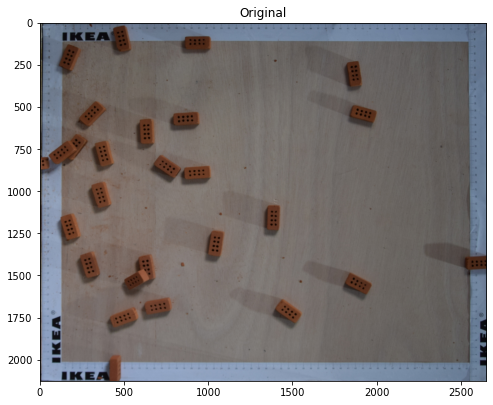

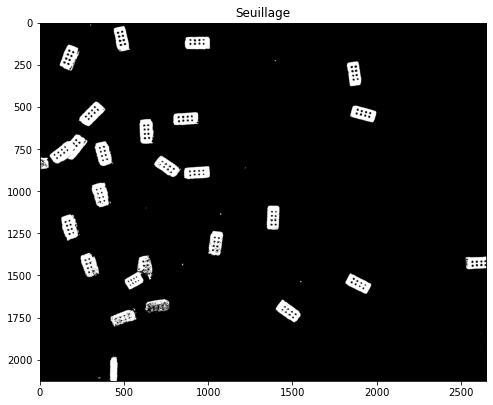

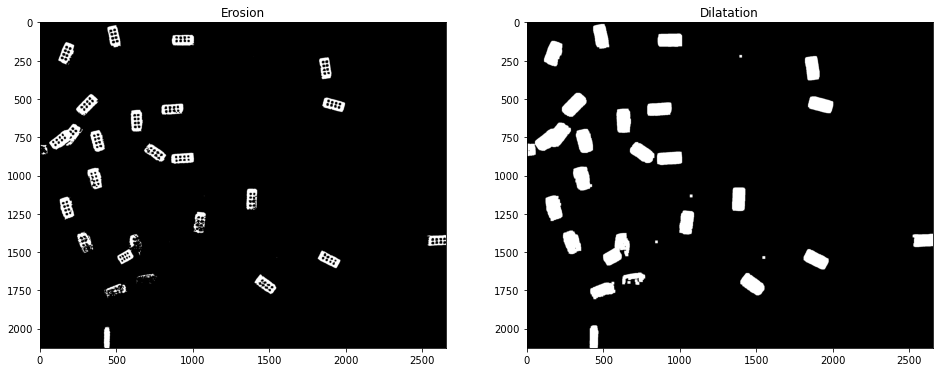

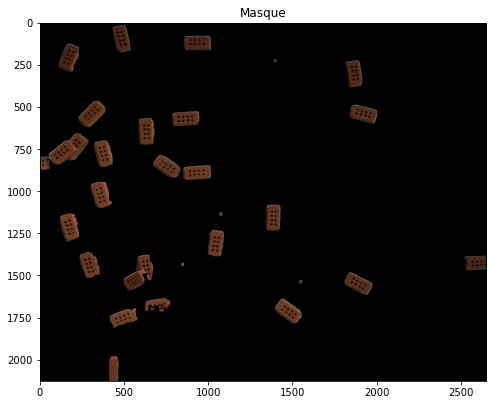

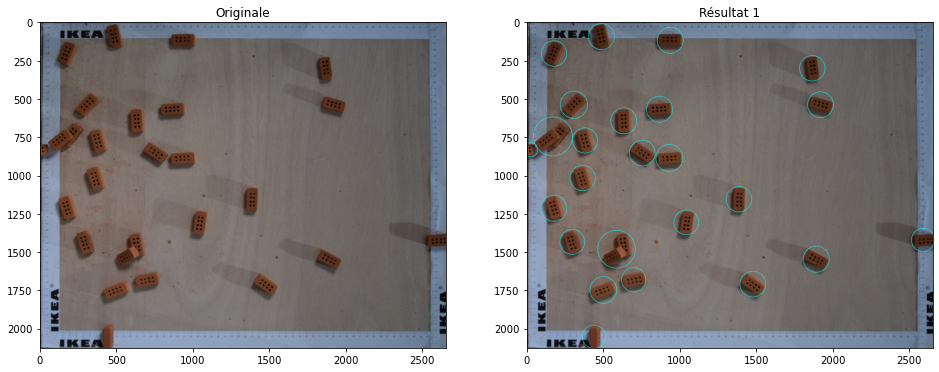

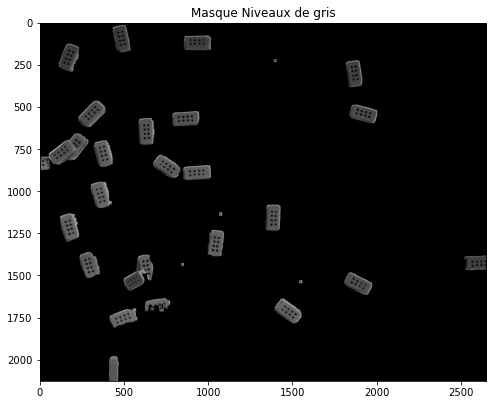

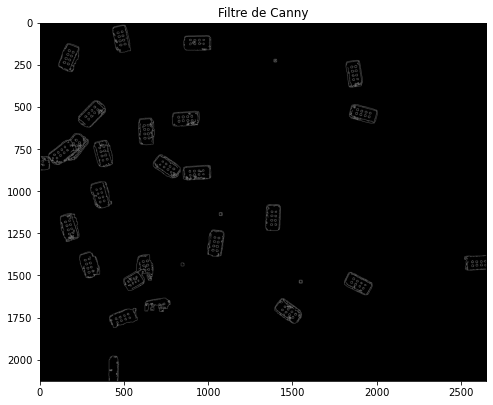

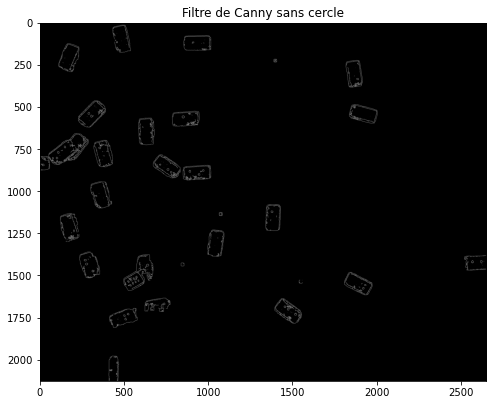

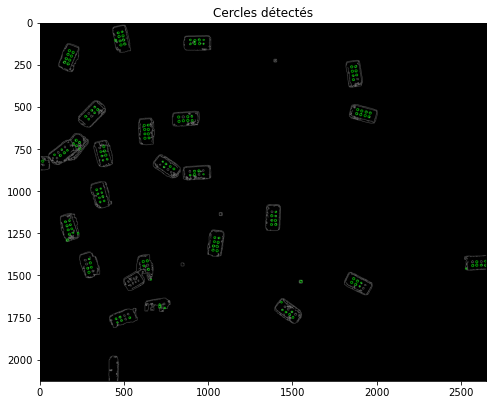

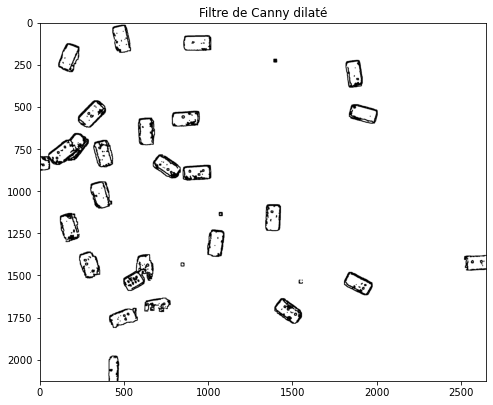

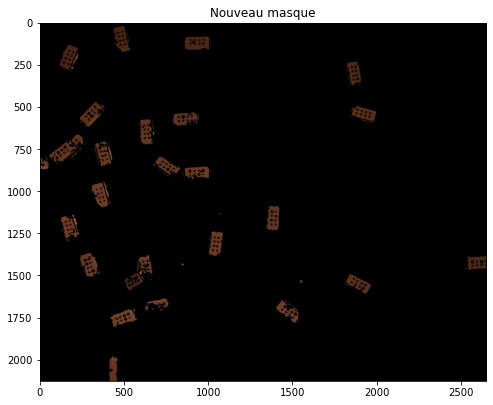

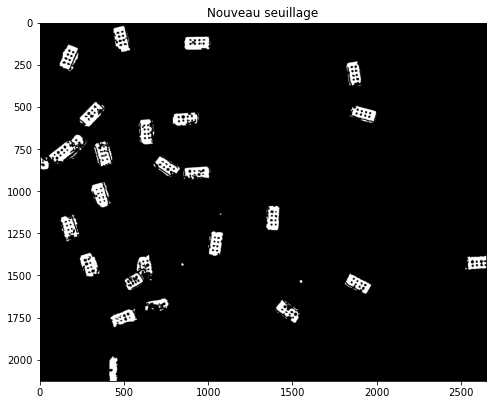

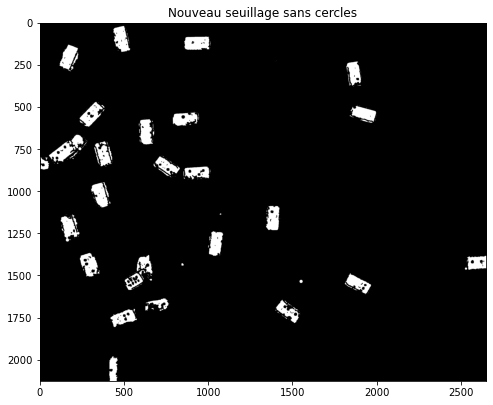

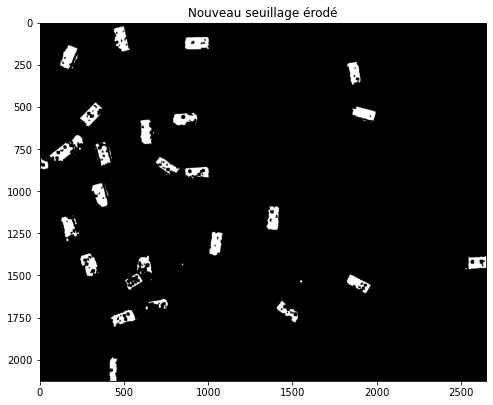

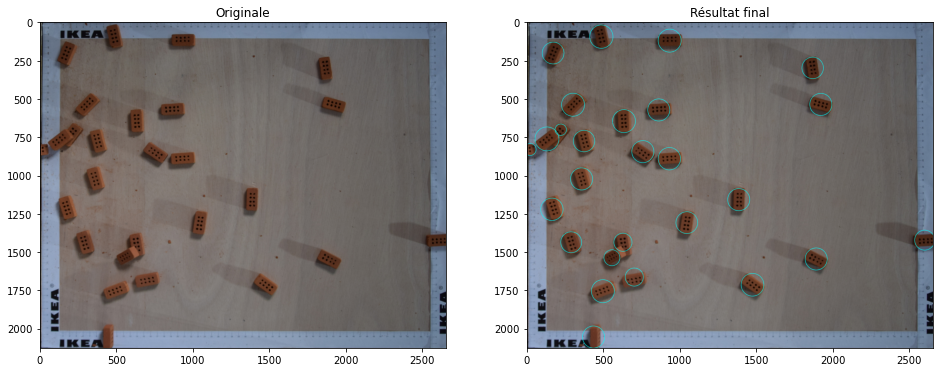

In [27]:
main("test/trail_only/test_", "test/trail_only/test__")
#main("test/trail_only/551", "test/trail_only/552")
#main("test/trail_only/plat", "test/trail_only/aa")   #otsu
#main("test/trail_only/plat", "test/trail_only/cc")
#main("test/trail_only/plat", "test/trail_only/bb")###
#main("test/trail_only/plat", "test/trail_only/c")
#main("test/trail_only/plat", "test/trail_only/b")
#main("test/trail_only/test_h", "test/trail_only/test_i")
#main("test/trail_only/test_h", "test/trail_only/test_jj")
#main("test/trail_only/test_h", "test/trail_only/test_ii")

Extraction des blocs ...


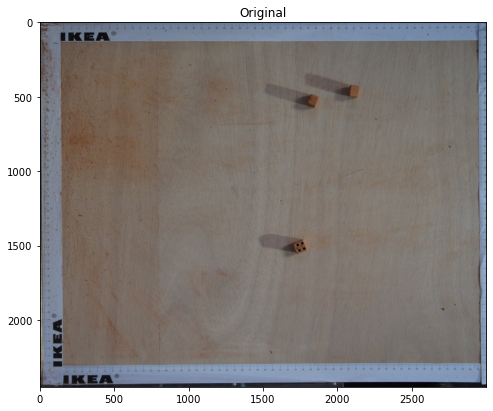

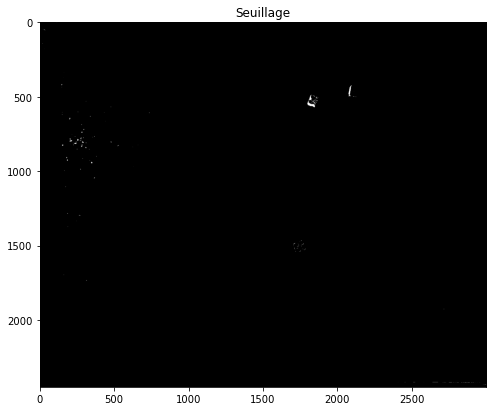

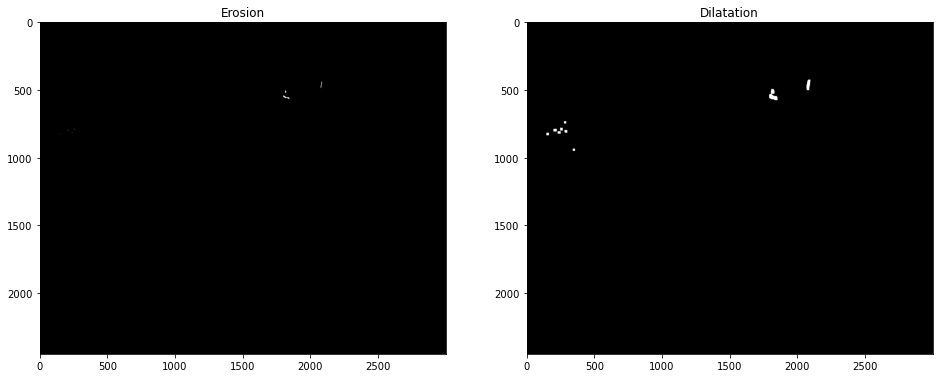

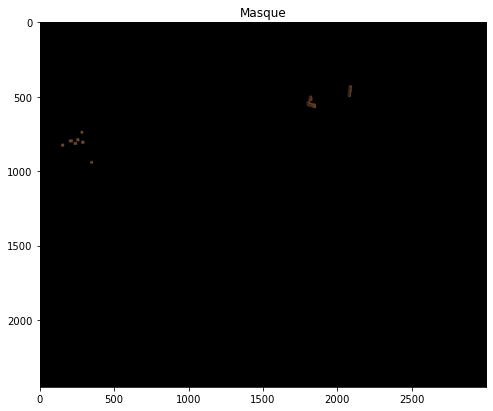

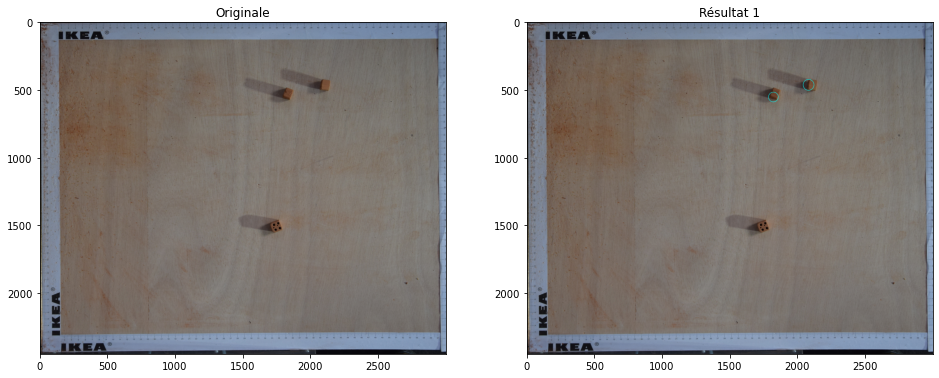

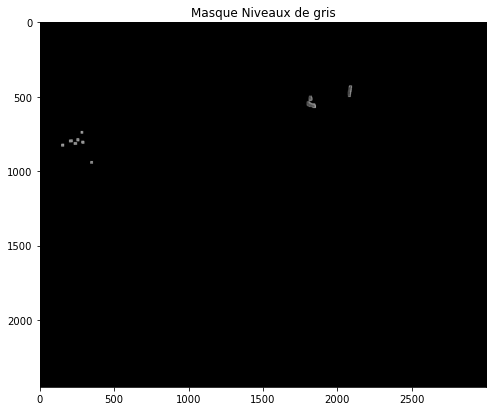

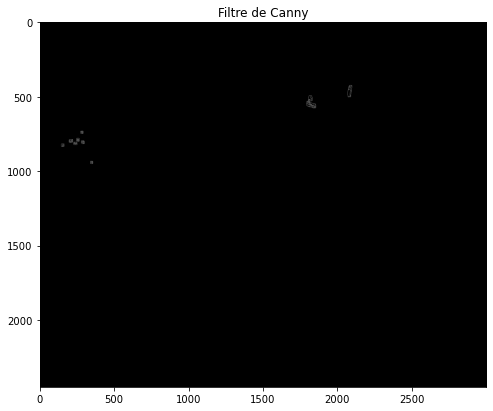

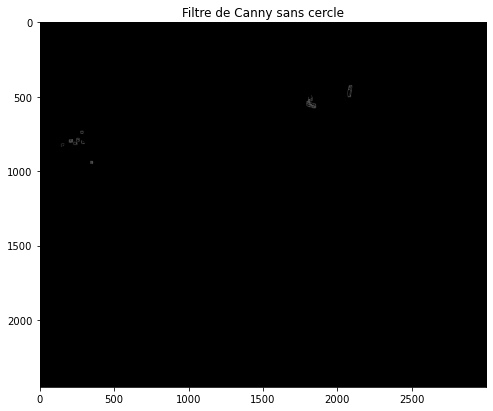

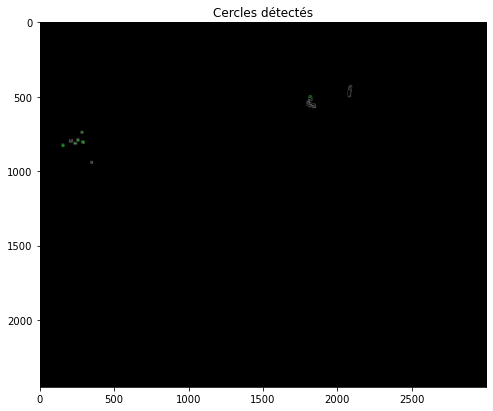

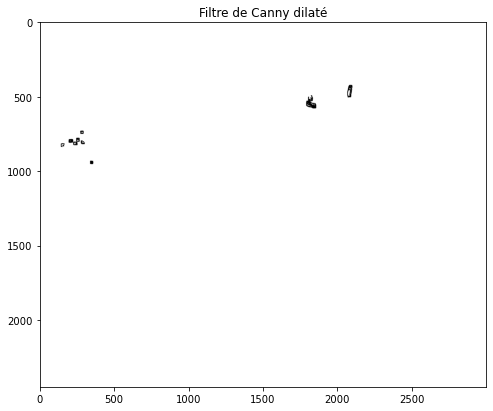

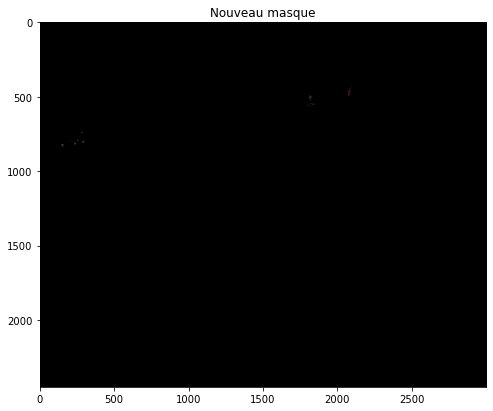

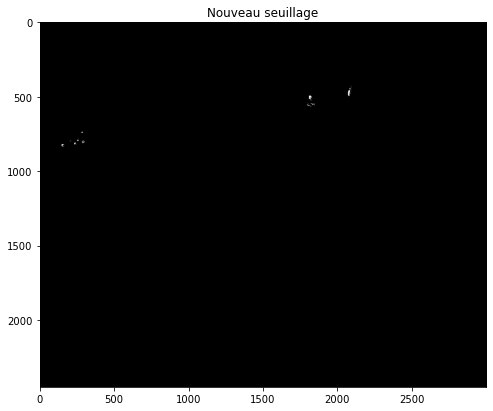

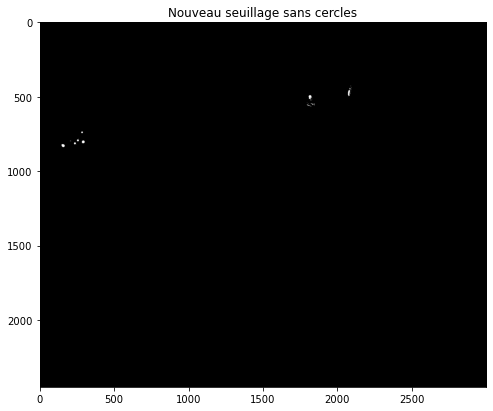

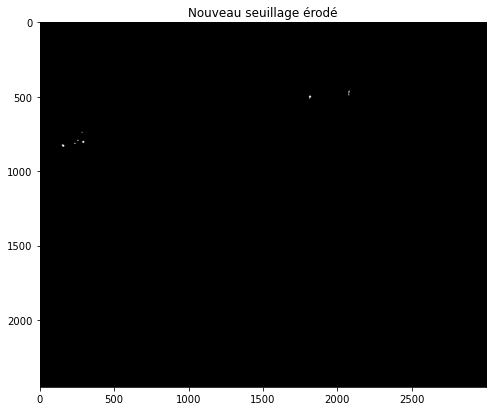

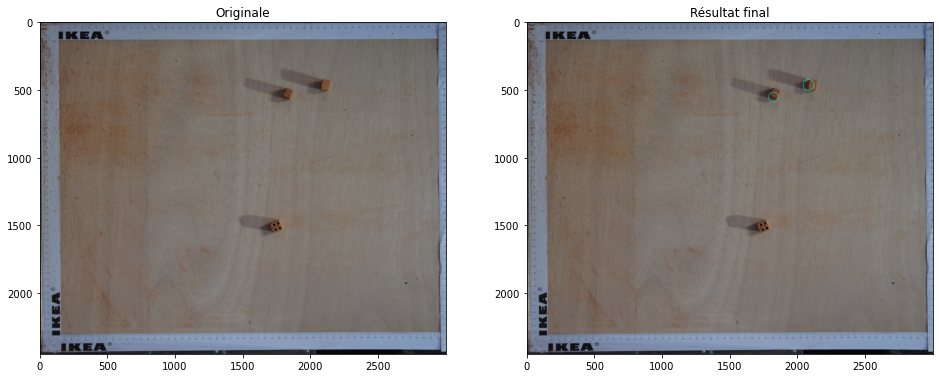

In [20]:
i = 1
main("test/trail_only/prog/prise0", "test/trail_only/prog/prise{}".format(i))